In [9]:
from train_dualencoder_cardiac import create_data_loaders, build_dautomap  
from pathlib import Path
from skimage import measure
from data.transforms import ifft2,fft2, complex_abs
from tqdm import tqdm
import h5py
import numpy as np
from matplotlib import pyplot as plt
from collections import namedtuple
from data import transforms
import torch
import pathlib

In [2]:
args = {'center_fractions':[0.08],'acceleration_factor':[4],'challenge':'singlecoil',
       'train_path':Path('/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_4x/train'),
        'exp_path':Path('/media/student1/NewVolume/MR_Reconstruction/experiments/dualencoder_cardiac/cardiac/acc_4x'),
        'validation_path':Path('/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_4x/validation'),
        'dataset_type':'cardiac',
       'resolution':160,
       'sample_rate':1.0,
       'batch_size':20,
        'device':'cuda',
        'data_parallel':False,
        'num_chans':32,
        'num_pools':4,
        'drop_prob':0
       }
# d_named = namedtuple("Employee", d.keys())(*d.values())
argsobj = namedtuple('args',args.keys())(*args.values())

In [3]:
train_loader, dev_loader,_= create_data_loaders(argsobj)

In [4]:
len(train_loader.dataset)

1841

In [ ]:
for img,ksp, tgt , _,_ in (dev_loader):
    print(img.shape,ksp.shape,tgt.shape)
    break

In [ ]:
img = img.unsqueeze(1)#.to(argsobj.device)
# ksp = ksp.to(argsobj.device)
# ksp = ksp.permute(0,3,1,2)
tgt = tgt.unsqueeze(1)#.to(argsobj.device)

img = img.float()
ksp = ksp.float()
tgt = tgt.float()

In [ ]:
ksp.shape , img.shape , tgt.shape

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
index = 3
import torch
plt.imshow(torch.log(torch.sqrt( ksp[index,:,:,0]**2 + ksp[index,:,:,1]**2) + 1e-10),cmap='gray')
plt.colorbar()

In [10]:
#### ksp_img = ifft2(ksp)
# ksp_img_abs = complex_abs(ksp_img)
# plt.imshow(ksp_img_abs[index,:,:],cmap='gray')
# plt.colorbar()

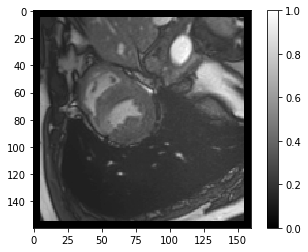

In [11]:
index=3
plt.imshow(tgt[index,0,:,:],cmap='gray')
plt.colorbar()

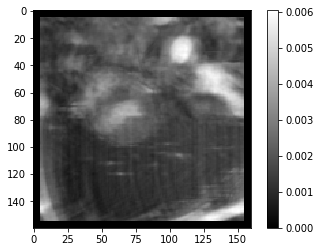

In [12]:
plt.imshow(img[index,0,:,:],cmap='gray')
plt.colorbar()


In [13]:
model = build_dautomap(argsobj)
model

dAUTOMAP(
  (domain_transform): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1), bias=False)
    (idft2): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1), bias=False)
  )
  (domain_transform2): GeneralisedIFT2Layer(
    (idft1): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1))
    (idft2): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1))
  )
  (refinement_block): Sequential(
    (0): Conv2d(2, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(64, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  )
)

In [14]:
dt_model = model.domain_transform
dt_model


GeneralisedIFT2Layer(
  (idft1): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1), bias=False)
  (idft2): Conv2d(2, 320, kernel_size=(160, 1), stride=(1, 1), bias=False)
)

In [15]:
dt_op = dt_model(ksp.permute(0,3,1,2).cuda())
dt_op.shape

torch.Size([20, 2, 160, 160])

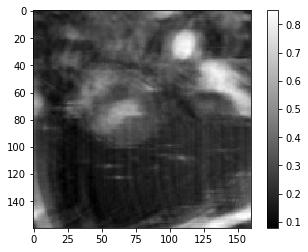

In [16]:
plt.imshow(torch.sqrt(dt_op[index,0,:,:]**2 + dt_op[index,1,:,:]**2).detach().cpu(),cmap='gray')
plt.colorbar()

# dataloader check!

In [ ]:
import h5py
fname = '/media/student1/NewVolume/MR_Reconstruction/datasets/fastmri_singlecoil/Train/file1002569.h5'
with h5py.File(fname,'r') as data:
    kspace_rect_cplx = data['kspace'][10]
kspace_rect_cplx.shape , kspace_rect_cplx.dtype

In [ ]:
import numpy as np
kspace_rect_abs = np.abs(kspace_rect_cplx)
plt.imshow(np.log(kspace_rect_abs+1e-10),cmap='gray')

In [ ]:
# kspace_rect = transforms.to_tensor(kspace_rect_cplx)
image_rect  = np.fft.fftshift(np.fft.ifft2(kspace_rect_cplx))

image_rect_abs = np.abs(image_rect)
print(image_rect_abs.shape , image_rect_abs.dtype)
plt.imshow(image_rect_abs,cmap='gray')
plt.colorbar()

In [ ]:
def center_crop(data,shape):
    assert 0 < shape[0] <= data.shape[-2]
    assert 0 < shape[1] <= data.shape[-1]
    w_from = (data.shape[-2] - shape[0]) // 2
    h_from = (data.shape[-1] - shape[1]) // 2
    
    w_to = w_from + shape[0]
    h_to = h_from + shape[1]
    return data[..., w_from:w_to, h_from:h_to]

In [ ]:
image_sq_abs = center_crop(image_rect_abs,(320,320))
print(image_sq_abs.shape ,  image_sq_abs.dtype)
plt.imshow(image_sq_abs,cmap='gray')
plt.colorbar()

In [ ]:
kspace_sq = np.fft.fftshift(np.fft.fft2(image_sq_abs, axes=(-2, -1))) *1000
kspace_sq.shape , kspace_sq.dtype
plt.imshow(np.log(np.abs(kspace_sq)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
kspace_tensor = transforms.to_tensor(kspace_sq)
kspace_tensor.shape  , kspace_tensor.dtype

In [ ]:
from common.subsample import MaskFunc
mask_func = MaskFunc(argsobj.center_fractions, argsobj.accelerations)

seed =  tuple(map(ord, fname))
masked_kspace_square, mask = transforms.apply_mask(kspace_tensor.float(), mask_func, seed)
masked_kspace_square.shape

In [ ]:
masked_kspace_square_cplx = masked_kspace_square[:,:,0].numpy() + 1j*masked_kspace_square[:,:,1].numpy()
masked_kspace_square_cplx.shape , masked_kspace_square_cplx.dtype

In [ ]:
plt.imshow(np.log(np.abs(masked_kspace_square_cplx)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
us_img  = (np.fft.ifft2(masked_kspace_square_cplx)) *10

us_img_abs = np.abs(us_img)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
# checking......

kspace_sq = np.fft.fftshift(np.fft.fft2(us_img_abs, axes=(-2, -1)))
kspace_sq.shape , kspace_sq.dtype
plt.imshow(np.log(np.abs(kspace_sq)+1e-10),cmap='gray')
plt.colorbar()

In [ ]:
us_img_abs, mean, std = transforms.normalize_instance(us_img_abs, eps=1e-11)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()
# us_img = us_img.clamp(-6, 6)

In [ ]:
# fs_img_abs, mean, std = transforms.normalize_instance(image_sq_abs, eps=1e-11)
fs_img_abs , _,_ = transforms.normalize_instance(image_sq_abs ,eps=1e-11)
print(fs_img_abs.shape , us_img_abs.dtype)
plt.imshow(fs_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
us_img_abs, mean, std = transforms.normalize(us_img_abs, eps=1e-11)
print(us_img_abs.shape , us_img_abs.dtype)
plt.imshow(us_img_abs,cmap='gray')
plt.colorbar()

In [ ]:
kspace_sq = np.fft.fftshift(np.fft.fft2(image_sq_abs, axes=(-2, -1)))
kspace_sq.shape , kspace_sq.dtype

# cardiac dataset check!

In [12]:
root = '/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_2x/train'
files = list(pathlib.Path(root).iterdir())
fname = str(files[0])

In [13]:
examples=[]

with h5py.File(fname,'r') as hf:
                fsvol = hf['volfs']
                num_slices = fsvol.shape[2]
                examples += [(fname, slice) for slice in range(num_slices)]

In [14]:
fname , slice = examples[0]
fname,slice

('/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_2x/train/67.h5',
 0)

In [15]:
with h5py.File(fname, 'r') as data:

            input_img  = data['img_volus_2x'][:,:,slice]
            input_kspace  = data['kspace_volus_2x'][:,:,slice]
#             input_kspace = npComplexToTorch(input_kspace)
    
            target = data['volfs'][:,:,slice]


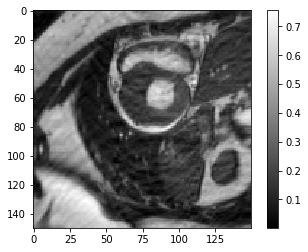

In [16]:
plt.imshow(input_img,cmap='gray')
plt.colorbar()

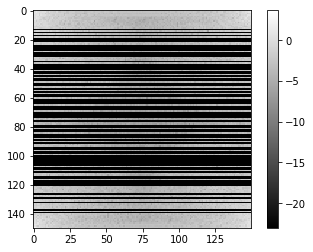

In [25]:
plt.imshow(np.log(np.abs(input_kspace) + 1e-10),cmap='gray')
plt.colorbar()

(150, 150)


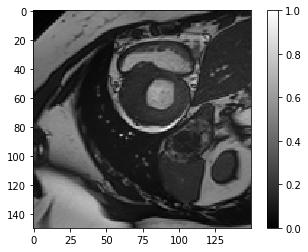

In [18]:
print(target.shape)
plt.imshow(target,cmap='gray')
plt.colorbar()

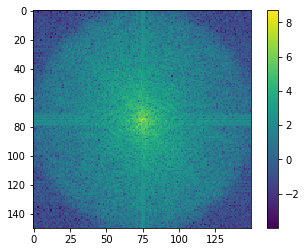

In [19]:
kspace =np.fft.fftshift(np.fft.fft2(target))
plt.imshow(np.log(np.abs(kspace)+1e-8))
plt.colorbar()

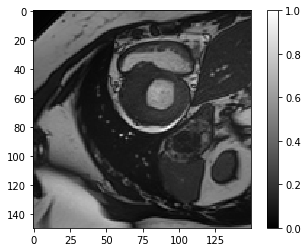

In [20]:
img = (np.fft.ifft2(kspace))
plt.imshow(np.abs(img),cmap='gray')
plt.colorbar()

In [21]:
kspace = transforms.to_tensor(kspace)
# kspace = kspace.unsqueeze(0)
kspace.shape

torch.Size([150, 150, 2])

In [22]:
# dt_op = dt_model(kspace.permute(0,3,1,2).float().cuda())
# dt_op = dt_op.detach().cpu()

In [23]:
# plt.imshow(torch.sqrt(dt_op[0,0,:,:]**2 + dt_op[0,1,:,:]**2),cmap='gray')
# plt.colorbar()

In [24]:
from common.subsample import MaskFunc
mask_func = MaskFunc(argsobj.center_fractions, argsobj.accelerations)

seed =  tuple(map(ord, fname))
masked_kspace_square, mask = transforms.apply_mask(kspace.float(), mask_func, seed)
masked_kspace_square.shape

AttributeError: 'args' object has no attribute 'accelerations'

In [ ]:
import torch
plt.imshow(torch.log(torch.sqrt( masked_kspace_square[:,:,0]**2 + masked_kspace_square[:,:,1]**2) + 1e-10),cmap='gray')
plt.colorbar()
print(masked_kspace_square.shape)

In [ ]:
masked_kspace_square2 = np.pad(masked_kspace_square,((5,5),(5,5),(0,0)),'constant',constant_values=(0,0))
masked_kspace_square2.shape

In [ ]:
masked_kspace_np = masked_kspace_square2[:,:,0] + 1j*masked_kspace_square2[:,:,1]
masked_kspace_np.shape , masked_kspace_np.dtype

In [ ]:
img = np.fft.ifft2(masked_kspace_np)
print(img.shape)
plt.imshow(np.abs(img),cmap='gray')
plt.colorbar()

# model loading

In [3]:
from models.models import UnetModel

In [4]:
def load_model(checkpoint_file):
    
    checkpoint = torch.load(checkpoint_file)
    args = checkpoint['args']
    model = UnetModel(
        in_chans=1,
        out_chans=1,
        chans=args.num_chans,
        num_pool_layers=args.num_pools,
        drop_prob=args.drop_prob
    ).to(args.device)
    
    
    

    model.load_state_dict(checkpoint['model'])
    return model

In [5]:
checkpoint_file = '/media/student1/NewVolume/MR_Reconstruction/experiments/dualencoder_cardiac/cardiac/acc_4x/best_model.pt'


In [6]:
model = load_model(checkpoint_file)

RuntimeError: Error(s) in loading state_dict for UnetModel:
	Missing key(s) in state_dict: "down_sample_layers.0.layers.0.weight", "down_sample_layers.0.layers.0.bias", "down_sample_layers.0.layers.4.weight", "down_sample_layers.0.layers.4.bias", "down_sample_layers.1.layers.0.weight", "down_sample_layers.1.layers.0.bias", "down_sample_layers.1.layers.4.weight", "down_sample_layers.1.layers.4.bias", "down_sample_layers.2.layers.0.weight", "down_sample_layers.2.layers.0.bias", "down_sample_layers.2.layers.4.weight", "down_sample_layers.2.layers.4.bias", "down_sample_layers.3.layers.0.weight", "down_sample_layers.3.layers.0.bias", "down_sample_layers.3.layers.4.weight", "down_sample_layers.3.layers.4.bias", "conv.layers.0.weight", "conv.layers.0.bias", "conv.layers.4.weight", "conv.layers.4.bias", "up_sample_layers.0.layers.0.weight", "up_sample_layers.0.layers.0.bias", "up_sample_layers.0.layers.4.weight", "up_sample_layers.0.layers.4.bias", "up_sample_layers.1.layers.0.weight", "up_sample_layers.1.layers.0.bias", "up_sample_layers.1.layers.4.weight", "up_sample_layers.1.layers.4.bias", "up_sample_layers.2.layers.0.weight", "up_sample_layers.2.layers.0.bias", "up_sample_layers.2.layers.4.weight", "up_sample_layers.2.layers.4.bias", "up_sample_layers.3.layers.0.weight", "up_sample_layers.3.layers.0.bias", "up_sample_layers.3.layers.4.weight", "up_sample_layers.3.layers.4.bias", "conv2.0.weight", "conv2.0.bias", "conv2.1.weight", "conv2.1.bias", "conv2.2.weight", "conv2.2.bias". 
	Unexpected key(s) in state_dict: "model1.domain_transform.idft1.weight", "model1.domain_transform.idft1.bias", "model1.domain_transform.idft2.weight", "model1.domain_transform.idft2.bias", "model1.domain_transform2.idft1.weight", "model1.domain_transform2.idft1.bias", "model1.domain_transform2.idft2.weight", "model1.domain_transform2.idft2.bias", "model1.refinement_block.0.weight", "model1.refinement_block.0.bias", "model1.refinement_block.2.weight", "model1.refinement_block.2.bias", "model1.refinement_block.4.weight", "model1.refinement_block.4.bias", "model2.down_sample_layers1.0.layers.0.weight", "model2.down_sample_layers1.0.layers.0.bias", "model2.down_sample_layers1.0.layers.4.weight", "model2.down_sample_layers1.0.layers.4.bias", "model2.down_sample_layers1.1.layers.0.weight", "model2.down_sample_layers1.1.layers.0.bias", "model2.down_sample_layers1.1.layers.4.weight", "model2.down_sample_layers1.1.layers.4.bias", "model2.down_sample_layers1.2.layers.0.weight", "model2.down_sample_layers1.2.layers.0.bias", "model2.down_sample_layers1.2.layers.4.weight", "model2.down_sample_layers1.2.layers.4.bias", "model2.down_sample_layers1.3.layers.0.weight", "model2.down_sample_layers1.3.layers.0.bias", "model2.down_sample_layers1.3.layers.4.weight", "model2.down_sample_layers1.3.layers.4.bias", "model2.down_sample_layers2.0.layers.0.weight", "model2.down_sample_layers2.0.layers.0.bias", "model2.down_sample_layers2.0.layers.4.weight", "model2.down_sample_layers2.0.layers.4.bias", "model2.down_sample_layers2.1.layers.0.weight", "model2.down_sample_layers2.1.layers.0.bias", "model2.down_sample_layers2.1.layers.4.weight", "model2.down_sample_layers2.1.layers.4.bias", "model2.down_sample_layers2.2.layers.0.weight", "model2.down_sample_layers2.2.layers.0.bias", "model2.down_sample_layers2.2.layers.4.weight", "model2.down_sample_layers2.2.layers.4.bias", "model2.down_sample_layers2.3.layers.0.weight", "model2.down_sample_layers2.3.layers.0.bias", "model2.down_sample_layers2.3.layers.4.weight", "model2.down_sample_layers2.3.layers.4.bias", "model2.conv.layers.0.weight", "model2.conv.layers.0.bias", "model2.conv.layers.4.weight", "model2.conv.layers.4.bias", "model2.up_sample_layers.0.layers.0.weight", "model2.up_sample_layers.0.layers.0.bias", "model2.up_sample_layers.0.layers.4.weight", "model2.up_sample_layers.0.layers.4.bias", "model2.up_sample_layers.1.layers.0.weight", "model2.up_sample_layers.1.layers.0.bias", "model2.up_sample_layers.1.layers.4.weight", "model2.up_sample_layers.1.layers.4.bias", "model2.up_sample_layers.2.layers.0.weight", "model2.up_sample_layers.2.layers.0.bias", "model2.up_sample_layers.2.layers.4.weight", "model2.up_sample_layers.2.layers.4.bias", "model2.up_sample_layers.3.layers.0.weight", "model2.up_sample_layers.3.layers.0.bias", "model2.up_sample_layers.3.layers.4.weight", "model2.up_sample_layers.3.layers.4.bias", "model2.conv2.0.weight", "model2.conv2.0.bias", "model2.conv2.1.weight", "model2.conv2.1.bias", "model2.conv2.2.weight", "model2.conv2.2.bias". 

In [ ]:
model

# reconstruction visualization

In [1]:
from skimage.measure import compare_psnr, compare_ssim

In [2]:
import h5py
fname_rec_1 = '/media/student1/NewVolume/MR_Reconstruction/experiments/dualencoder_cardiac/cardiac/acc_4x/results/98.h5'
fname_ori = '/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_4x/validation/98.h5'
fname_rec_2 = '/media/student1/NewVolume/MR_Reconstruction/experiments/unet_cardiac/cardiac/acc_4x/results/98.h5'
fname_rec_3 = '/media/student1/NewVolume/MR_Reconstruction/experiments/dautomap_cardiac/cardiac/acc_4x/results/98.h5'


In [3]:
hf_rec_1 = h5py.File(fname_rec_1)
print('Keys:', list(hf_rec_1.keys()))
print('Attrs:', dict(hf_rec_1.attrs))

hf_rec_2 = h5py.File(fname_rec_2)
print('Keys:', list(hf_rec_2.keys()))
print('Attrs:', dict(hf_rec_2.attrs))

hf_rec_3 = h5py.File(fname_rec_3)
print('Keys:', list(hf_rec_3.keys()))
print('Attrs:', dict(hf_rec_3.attrs))



hf_ori = h5py.File(fname_ori)
print('Keys:', list(hf_ori.keys()))
print('Attrs:', dict(hf_ori.attrs))

/home/student1/anaconda3/envs/fastmri/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


OSError: Unable to create file (unable to open file: name = '/media/student1/NewVolume/MR_Reconstruction/experiments/dualencoder_cardiac/cardiac/acc_4x/results/98.h5', errno = 2, error message = 'No such file or directory', flags = 15, o_flags = c2)

In [341]:
rec1 = hf_rec_1['reconstruction'][()]
print("rec",rec1.shape)

rec2 = hf_rec_2['reconstruction'][()]
print("rec",rec2.shape)


rec3 = hf_rec_3['reconstruction'][()]
print("rec",rec3.shape)

tgt = hf_ori['volfs'][()]
print("tgt",tgt.shape)

rec (19, 150, 150)
rec (19, 150, 150)
rec (19, 150, 150)
tgt (150, 150, 19)


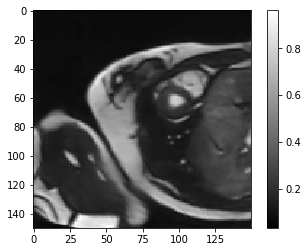

In [355]:
index =13

psnr=  28.030756777065093
ssim=  0.8652278189558543


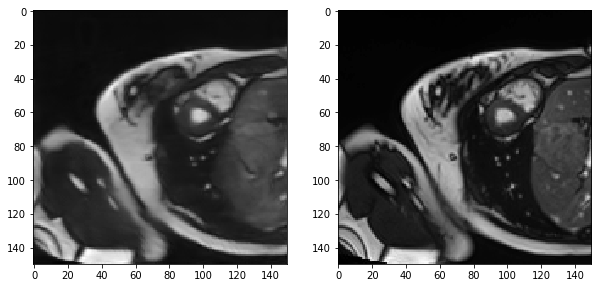

In [343]:
fig, ax = plt.subplots(1,2,figsize = (10, 15))
ax[0].imshow(rec1[index,:,:],cmap='gray');
ax[1].imshow(tgt[:,:,index],cmap='gray');
print("psnr= ",compare_psnr(tgt[:,:,index], rec1[index,:,:], data_range=tgt[:,:,index].max()))
print("ssim= ",compare_ssim(tgt[:,:,index], rec1[index,:,:],multichannel=True, data_range=tgt[:,:,index].max()))

psnr=  26.695636899305597
ssim=  0.8474926518497429


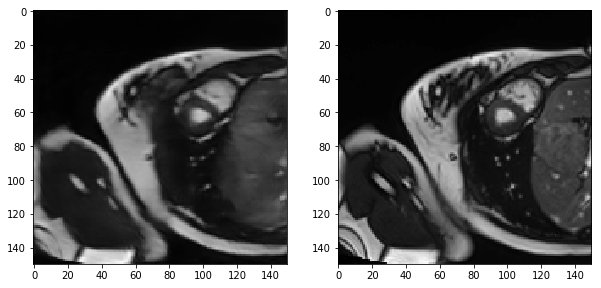

In [344]:
fig, ax = plt.subplots(1,2,figsize = (10, 15))
ax[0].imshow(rec2[index,:,:],cmap='gray');
ax[1].imshow(tgt[:,:,index],cmap='gray');
print("psnr= ",compare_psnr(tgt[:,:,index], rec2[index,:,:], data_range=tgt[:,:,index].max()))
print("ssim= ",compare_ssim(tgt[:,:,index], rec2[index,:,:],multichannel=True, data_range=tgt[:,:,index].max()))

psnr=  26.847088970611278
ssim=  0.8317028399660643


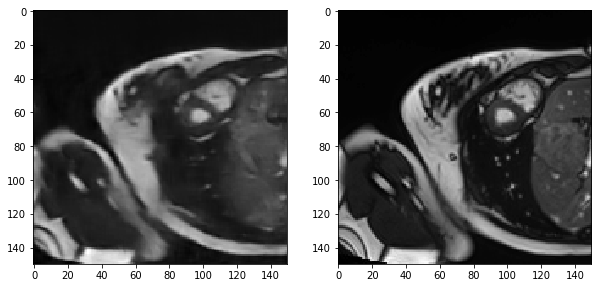

In [345]:
fig, ax = plt.subplots(1,2,figsize = (10, 15))
ax[0].imshow(rec3[index,:,:],cmap='gray');
ax[1].imshow(tgt[:,:,index],cmap='gray');
print("psnr= ",compare_psnr(tgt[:,:,index], rec3[index,:,:], data_range=tgt[:,:,index].max()))
print("ssim= ",compare_ssim(tgt[:,:,index], rec3[index,:,:],multichannel=True, data_range=tgt[:,:,index].max()))

(150, 150)


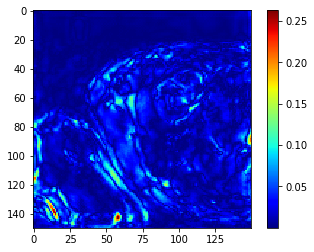

In [346]:
error = np.abs(rec1[index,:,:]-rec2[index,:,:])
print(error.shape)
plt.imshow(error,cmap='jet')
plt.colorbar()

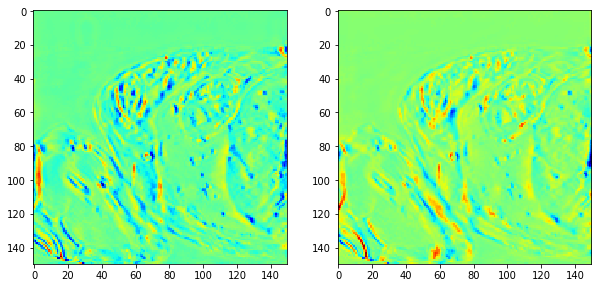

In [347]:
fig, ax = plt.subplots(1,2,figsize = (10, 15))
ax[0].imshow(rec1[index,:,:]-tgt[:,:,index],cmap='jet');

ax[1].imshow(rec2[index,:,:]-tgt[:,:,index],cmap='jet');


In [353]:
from common.subsample import MaskFunc

def get_input(fname):
    with h5py.File(fname, 'r') as data:

                target = data['volfs'][:,:,index]
                kspace_cmplx = np.fft.fftshift(np.fft.fft2(target,norm='ortho'))
                kspace = transforms.to_tensor(kspace_cmplx)


                mask_func = MaskFunc([0.08],[4])

                seed =  tuple(map(ord, str(fname)))
                masked_kspace_square, mask = transforms.apply_mask(kspace.float(), mask_func, seed)
                masked_kspace_np = masked_kspace_square[:,:,0].numpy() + 1j*masked_kspace_square[:,:,1].numpy()
                us_img = np.abs( np.fft.ifft2(masked_kspace_np))

#                 masked_kspace_square = np.pad(masked_kspace_square,((5,5),(5,5),(0,0)),'constant',constant_values=(0,0))

#                 us_img  = np.pad(us_img,(5,5),'constant',constant_values=(0,0))
#                 target = np.pad(target,(5,5),'constant',constant_values=(0,0))

                return us_img,target  #, masked_kspace_square ,  , str(fname.name) , slice

psnr=  17.97633390464085
ssim=  0.689935988043988


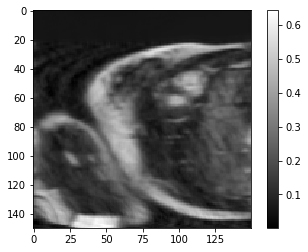

In [360]:
us_img,target = get_input(fname_ori)

plt.imshow(us_img*100,cmap='gray')
plt.colorbar()
print("psnr= ",compare_psnr(tgt[:,:,index], us_img*100, data_range=tgt[:,:,index].max()))
print("ssim= ",compare_ssim(tgt[:,:,index], us_img*100,multichannel=True, data_range=tgt[:,:,index].max()))

# reconstruction visulaization

In [22]:
import csv
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr, compare_ssim
from common.subsample import MaskFunc
from data import transforms
import h5py

In [37]:
from common.subsample import MaskFunc

def get_input(fname):
    with h5py.File(fname, 'r') as data:

                target = data['volfs'][:,:,slice]
                kspace_cmplx = np.fft.fftshift(np.fft.fft2(target,norm='ortho'))
                kspace = transforms.to_tensor(kspace_cmplx)


                mask_func = MaskFunc([0.08],[4])

                seed =  tuple(map(ord, str(fname)))
                masked_kspace_square, mask = transforms.apply_mask(kspace.float(), mask_func, seed)
                masked_kspace_np = masked_kspace_square[:,:,0].numpy() + 1j*masked_kspace_square[:,:,1].numpy()
                us_img = np.abs( np.fft.ifft2(masked_kspace_np))

#                 masked_kspace_square = np.pad(masked_kspace_square,((5,5),(5,5),(0,0)),'constant',constant_values=(0,0))

#                 us_img  = np.pad(us_img,(5,5),'constant',constant_values=(0,0))
#                 target = np.pad(target,(5,5),'constant',constant_values=(0,0))

                return us_img,target  #, masked_kspace_square ,  , str(fname.name) , slice

In [241]:
def compare_nmse(gt, pred):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2

In [38]:
fname_dual = '/media/student1/NewVolume/MR_Reconstruction/experiments/cardiac/acc_4x/dualencoder_cardiac/metrics.csv'
reader = pd.read_csv(fname_dual)

In [39]:
print(reader.head(n=3))

   Unnamed: 0 VOLUME  SLICE      MSE     NMSE   PSNR    SSIM
0           0  67.h5      0  0.00171  0.01555  27.68  0.8293
1           1  67.h5      1  0.00205  0.01672  26.89  0.8057
2           2  67.h5      2  0.00152  0.01702  28.19  0.8242


In [49]:
sorted = reader.sort_values('SSIM',ascending=False)
print(sorted.head(n=20))

      Unnamed: 0 VOLUME  SLICE      MSE     NMSE   PSNR    SSIM
252          252  98.h5      5  0.00087  0.01536  30.62  0.9033
929          929  39.h5      4  0.00132  0.02561  28.78  0.9014
928          928  39.h5      3  0.00113  0.02126  29.49  0.8990
118          118  26.h5      6  0.00101  0.01268  29.96  0.8955
930          930  39.h5      5  0.00126  0.02301  29.01  0.8919
927          927  39.h5      2  0.00096  0.01696  30.18  0.8913
888          888   0.h5      1  0.00069  0.00988  31.59  0.8898
249          249  98.h5      2  0.00106  0.01536  29.77  0.8883
220          220  71.h5      1  0.00067  0.01042  31.75  0.8867
937          937  39.h5     12  0.00112  0.01879  29.52  0.8854
938          938  39.h5     13  0.00119  0.02042  29.25  0.8837
887          887   0.h5      0  0.00076  0.01110  31.21  0.8836
931          931  39.h5      6  0.00134  0.02472  28.72  0.8834
116          116  26.h5      4  0.00107  0.01204  29.72  0.8830
119          119  26.h5      7  0.00118 

In [229]:
fname='89.h5'
slice=7

In [230]:
f_ori = '/media/student1/NewVolume/MR_Reconstruction/datasets/cardiac/acc_4x/validation/'+str(fname)

hf_ori = h5py.File(f_ori)
print('Keys:', list(hf_ori.keys()))
print('Attrs:', dict(hf_ori.attrs))

Keys: ['img_volus_4x', 'kspace_volus_4x', 'volfs']
Attrs: {}


/home/student1/anaconda3/envs/fastmri/lib/python3.6/site-packages/ipykernel_launcher.py:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  This is separate from the ipykernel package so we can avoid doing imports until


psnr=  22.042793092821302
ssim=  0.7055621150200541
nmse=  0.03239799541735538


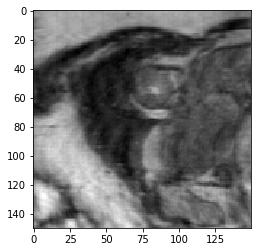

In [242]:
us_img,target = get_input(f_ori)
plt.imshow(us_img*100,cmap='gray')
print("psnr= ",compare_psnr(target, us_img/us_img.max(), data_range=target.max()))
print("ssim= ",compare_ssim(target, us_img/us_img.max(),multichannel=True, data_range=target.max()))
print("nmse= ",compare_nmse(target ,us_img/us_img.max() ))

psnr=  inf
ssim=  1.0
nmse=  0.0


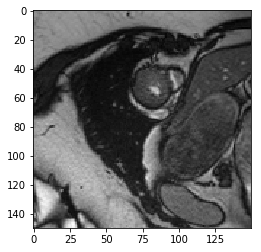

In [243]:
plt.imshow(target,cmap='gray')
print("psnr= ",compare_psnr(target, target, data_range=target.max()))
print("ssim= ",compare_ssim(target, target,multichannel=True, data_range=target.max()))
print("nmse= ",compare_nmse(target ,target ))

psnr=  25.785088722636296
ssim=  0.7341891267458226
nmse=  0.01368637945563721


/home/student1/anaconda3/envs/fastmri/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


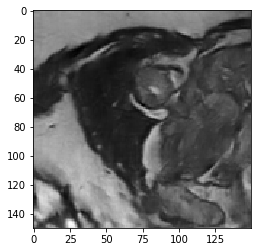

In [244]:
dauto_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/cardiac/acc_4x/dautomap_cardiac/results/'+str(fname)
hf_dauto_recons = h5py.File(dauto_recons_f)
dauto_recons = hf_dauto_recons['reconstruction'][()]
print("psnr= ",compare_psnr(target, dauto_recons[slice,:,:], data_range=target.max()))
print("ssim= ",compare_ssim(target, dauto_recons[slice,:,:] ,multichannel=True, data_range=target.max()))
print("nmse= ",compare_nmse(target ,dauto_recons[slice,:,:] ))
plt.imshow(dauto_recons[slice,:,:],cmap='gray')

psnr=  26.815656302612435
ssim=  0.7762326159778022
nmse=  0.010795227985319025


/home/student1/anaconda3/envs/fastmri/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


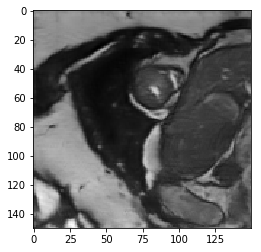

In [245]:
unet_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/cardiac/acc_4x/unet_cardiac/results/'+str(fname)
hf_unet_recons = h5py.File(unet_recons_f)
unet_recons = hf_unet_recons['reconstruction'][()]
print("psnr= ",compare_psnr(target, unet_recons[slice,:,:], data_range=target.max()))
print("ssim= ",compare_ssim(target, unet_recons[slice,:,:] ,multichannel=True, data_range=target.max()))
print("nmse= ",compare_nmse(target ,unet_recons[slice,:,:] ))


plt.imshow(unet_recons[slice,:,:],cmap='gray')

psnr=  27.30041425228533
ssim=  0.7833590223766969
nmse=  0.00965508327019512


/home/student1/anaconda3/envs/fastmri/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


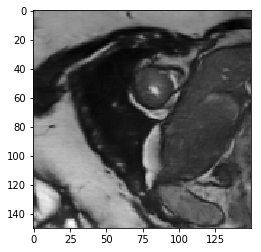

In [246]:
dual_recons_f = '/media/student1/NewVolume/MR_Reconstruction/experiments/cardiac/acc_4x/dualencoder_cardiac/results/'+str(fname)
hf_dual_recons = h5py.File(dual_recons_f)
dual_recons = hf_dual_recons['reconstruction'][()]
print("psnr= ",compare_psnr(target, dual_recons[slice,:,:], data_range=target.max()))
print("ssim= ",compare_ssim(target, dual_recons[slice,:,:] ,multichannel=True, data_range=target.max()))
print("nmse= ",compare_nmse(target ,dual_recons[slice,:,:] ))

plt.imshow(dual_recons[slice,:,:],cmap='gray')

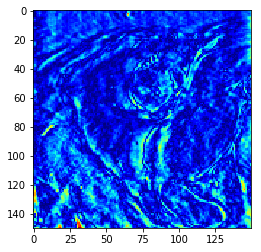

In [236]:
error_us = np.abs(target - us_img/us_img.max())
plt.imshow(error_us , cmap = 'jet')


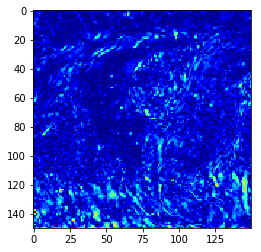

In [247]:
error_dauto = np.abs(target - dauto_recons[slice])
plt.imshow(error_dauto , cmap = 'jet')


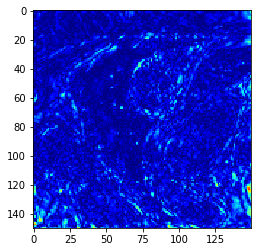

In [248]:
error_unet = np.abs(target - unet_recons[slice])
plt.imshow(error_unet , cmap = 'jet')


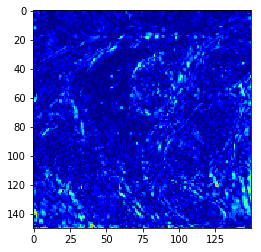

In [249]:
error_dual = np.abs(target - dual_recons[slice])
plt.imshow(error_dual , cmap = 'jet')